In [17]:
import argparse
import os
import shutil
from pathlib import Path
import jax
import numpy as np
from torch.utils.data import random_split
from flax.metrics import tensorboard
import jax.numpy as jnp
from flax.training import train_state, orbax_utils
import orbax.checkpoint
from flax import linen as nn
import optax
import sys
sys.argv = ['']

2023-05-17 20:59:30.148999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Argument

In [8]:

parser = argparse.ArgumentParser()

parser.add_argument('--test_ratio', default=0.2, type=float,
                    help='Test ratio for splitting the dataset')
parser.add_argument('--batch_size', default=64, type=int,
                    help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
parser.add_argument('--epochs', default=400, type=int)
parser.add_argument('--accum_iter', default=1, type=int,
                    help='Accumulate gradient iterations (for increasing the effective batch size under memory constraints)')

# model parameters
parser.add_argument('--input_size', default=224, type=int,
                    help='images input size')
parser.add_argument('--n_input_vars', default=3, type=int,
                    help='images input size')

# optimizer parameters
parser.add_argument('--weight_decay', type=float, default=0.05,
                    help='weight decay (default: 0.05)')

parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                    help='learning rate (absolute lr)')
parser.add_argument('--blr', type=float, default=1e-3, metavar='LR',
                    help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
parser.add_argument('--min_lr', type=float, default=0., metavar='LR',
                    help='lower lr bound for cyclic schedulers that hit 0')

parser.add_argument('--warmup_epochs', type=int, default=40, metavar='N',
                    help='epochs to warmup LR')

# dataset parameters
parser.add_argument('--purple_air_dir', default='../../NASA_Citizen_Science/data/PurpleAir/SF', type=str,
                    help='pa dataset path')

parser.add_argument('--air_now_dir', default='../../NASA_Citizen_Science/data/airNow/stations', type=str,
                    help='AirNow dataset path')

parser.add_argument('--pair_file', default='../../NASA_Citizen_Science/metrics/min_great_circle_df.csv', type=str,
                    help='Distance file path')

parser.add_argument('--output_dir', default='./output_dir',
                    help='path where to save, empty for no saving')
parser.add_argument('--log_dir', default='./output_dir',
                    help='path where to tensorboard log')
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')
parser.add_argument('--seed', default=0, type=int)
parser.add_argument('--resume', default='',
                    help='resume from checkpoint')

parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                    help='start epoch')
parser.add_argument('--num_workers', default=10, type=int)
parser.add_argument('--pin_mem', action='store_true',
                    help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
parser.set_defaults(pin_mem=True)

args = parser.parse_args()

#### DataLoader

In [11]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from torch.utils.data import DataLoader, Dataset
from pathlib import Path 
from os.path import isfile

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class LCSFEM_Bias_Dataset(Dataset):
    def __init__(self, pair_file, pa_dir, an_dir, transform=None, target_transform=None, ln_scale = False):
        an_dir = Path(an_dir)
        pa_dir = Path(pa_dir)
        self.data = self.load_file(pair_file, pa_dir, an_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.ln_scale = ln_scale
        
        self.an_dir = Path(an_dir)
        self.pa_dir = Path(pa_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx][-4:-1].values
        label = self.data.iloc[idx][-1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.ln_scale:
            label = jnp.log(label)
        return sample.astype(float), label.astype(float)
    
    def load_file(self, pair_file, pa_dir, an_dir, pair_dis = 1):
        train_data = pd.DataFrame()
        min_df = pd.read_csv(pair_file, index_col = 0)
        subtracted = min_df[min_df['1']< pair_dis]
        for i, row in subtracted.iterrows():
            pa_name = i
            if (isfile(pa_dir/ pa_name)):
                pa_data = pd.read_csv(pa_dir/ pa_name, index_col=0)
                pa_data['datetime'] = pd.to_datetime(pa_data['datetime'])
                pa_data.index = pa_data['datetime']
                pa_data.drop(['label'], axis=1, inplace=True) # remove label column
                pa_data = pa_data.resample('H').mean().dropna()
                pa_data['PM25'] = pa_data.loc[:, ['pm25_A', 'pm25_B']].mean(axis=1)
                pa_data = pa_data[pa_data['PM25'] <= 200]

                an_data = pd.read_csv(an_dir / row["0"], index_col = 0)
                an_data.index = pd.to_datetime(an_data['datetime'])
                an_data = an_data[an_data['concentration'] > 0]
                
                sub_data = pa_data[pa_data.index.isin(an_data.index)].copy()
                sub_data['an'] = an_data[an_data.index.isin(pa_data.index)]['concentration'].values
                
                train_data = pd.concat([train_data, sub_data])

        return train_data
       

class NumpyLoader(DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

#### Model

In [13]:

from typing import Callable, Sequence
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

#### Train function

In [14]:
@jax.vmap
def mse_loss(preds, targets):
  return jnp.mean((preds.flatten() - targets)**2)

@jax.jit
def apply_model(state, x, y):
    def loss_fn(params):
        y_hat = state.apply_fn({'params': params}, x)         # make forward pass
        loss = mse_loss(y_hat, y).mean()
        return loss, y_hat
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, y_hat), grads = grad_fn(state.params)
    return state, loss, grads

def train_one_epoch(state, training_generator):
    train_loss = []
    for i, (x, y) in enumerate(training_generator):
        state, loss, grads = apply_model(state, x, y)

        train_loss.append(loss.item())

        state = state.apply_gradients(grads=grads)
    train_loss = jnp.mean(jnp.array(train_loss))
    return state, train_loss


#### Eval Function

In [15]:
@jax.vmap
def mse_loss(preds, targets):
  return jnp.mean((preds.flatten() - targets)**2)

def eval(state, testing_generator):
    eval_loss = []
    for i, (x,y) in enumerate(testing_generator):
        # variables = model.init(rng, x)
        def loss_fn(params):
            # make forward pass
            y_hat = state.apply_fn({'params': params}, x)

            loss = mse_loss(y_hat, y).mean()
            eval_loss.append(loss.primal.item())
            return loss
        grads = jax.grad(loss_fn)(state.params)
        # eval_loss.append(grads)
    eval_loss = jnp.mean(jnp.array(eval_loss))
    return eval_loss

In [18]:
# fix the seed for reproducibility
seed = args.seed
jax.random.PRNGKey(seed)
np.random.seed(seed)
rng = jax.random.PRNGKey(seed)
rng, key = jax.random.split(rng)

# init the dataset
dataset = LCSFEM_Bias_Dataset(args.pair_file, args.purple_air_dir, args.air_now_dir)
len_test = int(len(dataset) * args.test_ratio)
train_set, test_set = random_split(dataset, [(len(dataset) - len_test), len_test])
print(len(train_set), len(test_set))
print(len(dataset))


training_generator = NumpyLoader(train_set, batch_size=args.batch_size, num_workers=0)
testing_generator = NumpyLoader(test_set, batch_size=args.batch_size, num_workers=0)

# init the model
model = MLP([args.n_input_vars, 256, 128, 64, 1])

# init train state
init_data = jnp.ones((args.batch_size, args.n_input_vars), jnp.float32)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=model.init(rng, init_data)['params'],
    tx=optax.adam(args.lr),
)

# init eval state
rng, z_key, eval_rng = jax.random.split(rng, args.n_input_vars)
z = jax.random.normal(z_key, (64, 256))

# init checkpoint dir
ckpt_dir = 'ckpts'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

# checkpoint
config = {'batch_size': args.batch_size, 'accum_iter': args.accum_iter}
ckpt = {'model': state, 'config': config, 'data': training_generator}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('ckpts/orbax/single_save', ckpt, save_args=save_args)
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=2, create=True)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    'ckpts/orbax/managed', orbax_checkpointer, options)

if checkpoint_manager.latest_step() is not None:  # existing checkpoint present
  # Use convenience function to construct args.
  shardings = jax.tree_map(lambda x: x.sharding, ckpt)
  restore_args = checkpoint_utils.construct_restore_args(
                    ckpt, shardings)
  # Directly construct args.
  restore_args = jax.tree_map(
    lambda x: ArrayRestoreArgs(
        # Restore as object. Could also be np.ndarray, int, or others.
        restore_type=jax.Array,
        # Cast the restored array to a specific dtype.
        dtype=np.float32,
        mesh=x.sharding.mesh,
        mesh_axes=x.sharding.spec,
        # Padding or truncation may occur. Ensure that the shape matches the
        # saved shape!
        global_shape=x.shape,
    ),
    train_state)
  # Note the use of plural 'items' and 'restore_kwargs'. This is because we may
  # be managing multiple items, as shown in the previous section. It is also
  # valid to just have one item, as shown here.
  restored = checkpoint_manager.restore(checkpoint_manager.latest_step(), 
                items=ckpt, restore_kwargs=restore_args)

# tensorboard
summary_writer = tensorboard.SummaryWriter('logs/l2_regression')

for epoch in range(args.epochs):
    # training loop
    state, train_loss = train_one_epoch(state, training_generator)

    # save checkpoint
    checkpoint_manager.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    # evaluation loop
    eval_loss = eval(state, testing_generator)

    # print loss and write the tensorboard
    print(f'Epoch: {epoch:d}, train_loss: {train_loss:.4f}, eval_loss: {eval_loss:.4f}')
    summary_writer.scalar('train_loss', train_loss, epoch)
    summary_writer.scalar('eval_loss', eval_loss, epoch)

82954 20738
103692
Epoch: 0, train_loss: 1735290368.0000, eval_loss: 6817127936.0000
Epoch: 1, train_loss: 2883278848.0000, eval_loss: 21357.5176
Epoch: 2, train_loss: 117787.3125, eval_loss: 4593.3481
Epoch: 3, train_loss: 1791952.6250, eval_loss: 19546924.0000
Epoch: 4, train_loss: 33901232.0000, eval_loss: 31.6151
Epoch: 5, train_loss: 32.4443, eval_loss: 51.1328
Epoch: 6, train_loss: 2102.4893, eval_loss: 44250.7617
Epoch: 7, train_loss: 22171316.0000, eval_loss: 25.9926
Epoch: 8, train_loss: 26.5348, eval_loss: 25.8738
Epoch: 9, train_loss: 26.3618, eval_loss: 25.6470
Epoch: 10, train_loss: 26.0416, eval_loss: 25.2281
Epoch: 11, train_loss: 25.4682, eval_loss: 24.4928
Epoch: 12, train_loss: 24.4748, eval_loss: 23.2540
Epoch: 13, train_loss: 22.8574, eval_loss: 21.3071
Epoch: 14, train_loss: 20.4660, eval_loss: 18.6506
Epoch: 15, train_loss: 17.7099, eval_loss: 16.2612
Epoch: 16, train_loss: 15.8131, eval_loss: 15.0506
Epoch: 17, train_loss: 14.7639, eval_loss: 14.1590
Epoch: 18, t

#### create prediction and plot it

In [26]:
eval_y_pred = jnp.array([])
eval_y_obs = jnp.array([])
for i, (x,y) in enumerate(testing_generator):
    # make forward pass
    y_hat = state.apply_fn({'params': state.params}, x)
    eval_y_obs = jnp.concatenate([eval_y_obs, y.flatten()])
    eval_y_pred = jnp.concatenate([eval_y_pred, y_hat.flatten()])


In [28]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Prediction (calibrated PM2.5)')

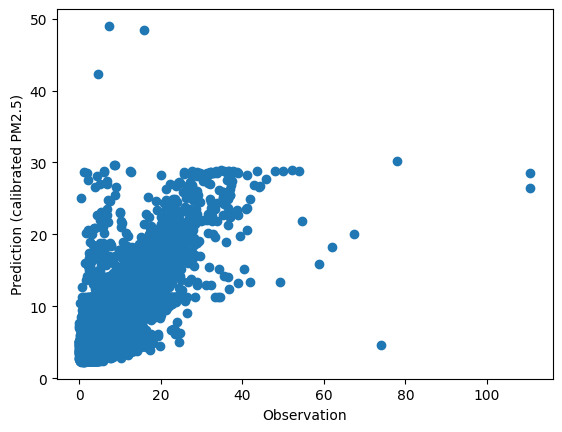

In [33]:
plt.scatter(eval_y_obs, eval_y_pred)
plt.xlabel('Observation')
plt.ylabel('Prediction (calibrated PM2.5)')

In [30]:
%load_ext tensorboard
%tensorboard --logdir=.